<a href="https://colab.research.google.com/github/nasrinrastgoo/data_mining_titanicclassification/blob/main/DMT_titanicClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Data Mining Techniques

Data Mining Practice and Theory

Titanic Explore & Classification

In [1]:
import pandas as pd
import sklearn as sk
from sklearn.model_selection import cross_val_score,StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import xgboost
from xgboost.sklearn import XGBClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# Set path to dat location
data_path = "/content/drive/MyDrive/DMT-data/"

In [4]:
pd.set_option('display.max_rows', None)

# Task 2

In [7]:
# load training dataset
titanic_train = pd.read_csv(data_path+'train.csv', delimiter = ',')
titanic_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


###Training data summary

In [8]:
titanic_train.info()
titanic_train['Age'].describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

In [9]:
titanic_train['Survived'].value_counts(1)

0    0.616162
1    0.383838
Name: Survived, dtype: float64

In [10]:
# passenger class percentage
passenger_class = pd.concat([titanic_train['Pclass'].value_counts(), 
                titanic_train['Pclass'].value_counts(normalize=True).mul(100)],axis=1, keys=('counts','percentage'))
passenger_class

,counts,percentage
3,491,55.106622
1,216,24.242424
2,184,20.650954


In [11]:
#number of missing data
titanic_train.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [12]:
# to find the unique values in columns
for col in titanic_train.columns:
    print(col, len(titanic_train[col].unique()))

PassengerId 891
Survived 2
Pclass 3
Name 891
Sex 2
Age 89
SibSp 7
Parch 7
Ticket 681
Fare 248
Cabin 148
Embarked 4


Initial investigation in the dataset shows that 55.11% of passengers are in class 3, 20.65% are in class 2, and 24.24% are in class 1; besides, the average age of passengers is 29.70 years old, and 38.38% of the passengers survived.

# Plots
To predict survived in the test data,
plots are demonstrated to figure out the relations between survived and the
attributes in the training data.

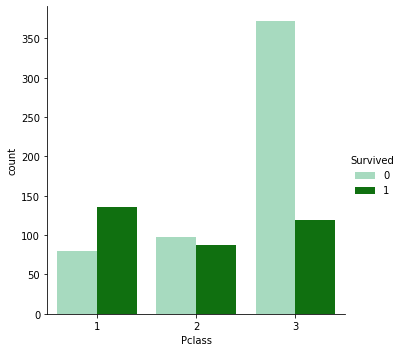

In [13]:
sns.catplot(x='Pclass', hue='Survived', data=titanic_train, kind='count', palette=sns.color_palette(['#9FE2BF', 'green']))
plt.show()

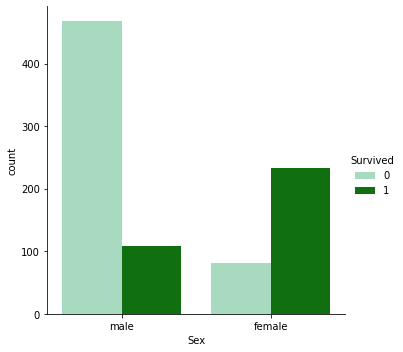

In [14]:
sns.catplot(x='Sex', hue='Survived', data=titanic_train, kind='count', palette=sns.color_palette(['#9FE2BF', 'green']))
plt.show()

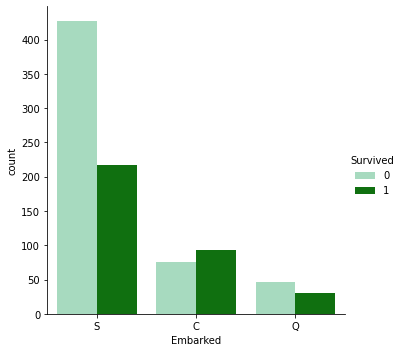

In [15]:
# Embarked and Survived
sns.catplot(x='Embarked', hue='Survived', data=titanic_train, kind='count', palette=sns.color_palette(['#9FE2BF', 'green']))
plt.show()

### Data Preprocessed

In [16]:
# drop columns: cabin, name, ticket
titanic_train.drop(columns= ['Name', 'Ticket', 'Cabin'], inplace= True)

# replace age missing values with the mean
mean_age = titanic_train.Age.mean()
titanic_train.Age.fillna(mean_age, inplace = True)
mean_age

# replace embark missing values with the mode
mode_embark = titanic_train.Embarked.mode()[0]
titanic_train.Embarked.fillna(mode_embark, inplace = True)
titanic_train.Embarked.mode()

titanic_train.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
dtype: int64

"Age" attribute contains 177 missing values, they are
replaced with average of this column’s values, 29.70. The next attribute that
has missing values is "Embarked", which is port of embarkation, and its type is
object. These missing values are replaced with the mode of this column’s values,
which is "S".

In [17]:
# replace data in sex to 0,1
titanic_train.Sex.replace('male', 0, inplace = True)
titanic_train.Sex.replace('female', 1, inplace = True)

# replace data in embarked to 0,1,2
titanic_train.Embarked.replace('S', 0, inplace = True)
titanic_train.Embarked.replace('C', 1, inplace = True)
titanic_train.Embarked.replace('Q', 2, inplace = True)

titanic_train

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,0,22.000000,1,0,7.2500,0
1,2,1,1,1,38.000000,1,0,71.2833,1
2,3,1,3,1,26.000000,0,0,7.9250,0
3,4,1,1,1,35.000000,1,0,53.1000,0
4,5,0,3,0,35.000000,0,0,8.0500,0
...,...,...,...,...,...,...,...,...,...
886,887,0,2,0,27.000000,0,0,13.0000,0
887,888,1,1,1,19.000000,0,0,30.0000,0
888,889,0,3,1,29.699118,1,2,23.4500,0
889,890,1,1,0,26.000000,0,0,30.0000,1


# Heatmap
shows the correlation (relationship) between
attributes. The best relationship among "survival" and
other features is "sex", and
then "Fare" and "Embarked"
in the Titanic train data.

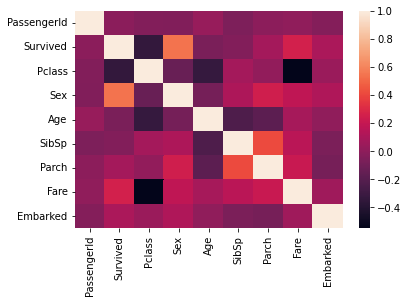

In [18]:
corr = titanic_train.corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns)

In [19]:
titanic_test = pd.read_csv(data_path+'test.csv', delimiter = ',')
titanic_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [20]:
# drop columns: cabin, name, ticket
titanic_test.drop(columns= ['Name', 'Ticket', 'Cabin'], inplace= True)

# replace data in sex to 0,1
titanic_test.Sex.replace('male', 0, inplace = True)
titanic_test.Sex.replace('female', 1, inplace = True)

# replace data in embarked to 0,1,2
titanic_test.Embarked.replace('S', 0, inplace = True)
titanic_test.Embarked.replace('C', 1, inplace = True)
titanic_test.Embarked.replace('Q', 2, inplace = True)

titanic_test

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,892,3,0,34.5,0,0,7.8292,2
1,893,3,1,47.0,1,0,7.0000,0
2,894,2,0,62.0,0,0,9.6875,2
3,895,3,0,27.0,0,0,8.6625,0
4,896,3,1,22.0,1,1,12.2875,0
...,...,...,...,...,...,...,...,...
413,1305,3,0,NaN,0,0,8.0500,0
414,1306,1,1,39.0,0,0,108.9000,1
415,1307,3,0,38.5,0,0,7.2500,0
416,1308,3,0,NaN,0,0,8.0500,0


In [21]:
mean_fare = titanic_test.Fare.mean()
titanic_test.Fare.fillna(mean_fare, inplace = True)

In [22]:
titanic_test['SibSp'].isnull().sum()


0

### Regression models

In [23]:
y = titanic_train["Survived"]
features = ['Pclass', 'Sex', 'Parch','Fare','Embarked']
X = titanic_train[features]

X_test = pd.DataFrame(data=titanic_test,columns= features)


**Random Forrest**

In [24]:
'''
Random Forrest model
Run the model on the train and data to see the accuracy
'''
X_t, X_v, y_t, y_v = train_test_split(X, y, test_size=.25, random_state=2)
model_RF = RandomForestClassifier( n_estimators=1000, max_depth=3, random_state=2,oob_score = True)
model_RF.fit(X_t, y_t)
y_pred = model_RF.predict(X_v)
Accuracy = accuracy_score(y_v, y_pred)
print("RF Accuracy: %.2f%%" % (Accuracy * 100.0))

RF Accuracy: 78.92%


In [29]:
#predict test data

model_RF.fit(X, y)
predictions = model_RF.predict(X_test)

submission_RF = pd.read_csv(data_path+'gender_submission.csv', delimiter = ',')
submission_RF['Survived'] = predictions
submission_RF.to_csv('submission_RF.csv', index=False)

**XGB**

In [30]:
'''
xgb
Run the model on the train and data to see the accuracy
'''

model_xgb = xgboost.XGBClassifier(objective="binary:logistic", n_estimators=100, random_state=42, eval_metric=["auc", "error", "error@0.6"])
model_xgb.fit(X_t, y_t, eval_set=[(X_v, y_v)])
y_pred_xgb = model_xgb.predict(X_v)

accuracy = accuracy_score(y_v, y_pred_xgb)
print("Xgb Accuracy: %.2f%%" % (accuracy * 100.0))

[0]	validation_0-auc:0.847245	validation_0-error:0.210762	validation_0-error@0.6:0.412556
[1]	validation_0-auc:0.84571	validation_0-error:0.210762	validation_0-error@0.6:0.412556
[2]	validation_0-auc:0.850855	validation_0-error:0.2287	validation_0-error@0.6:0.251121
[3]	validation_0-auc:0.850606	validation_0-error:0.210762	validation_0-error@0.6:0.251121
[4]	validation_0-auc:0.849942	validation_0-error:0.2287	validation_0-error@0.6:0.251121
[5]	validation_0-auc:0.850108	validation_0-error:0.2287	validation_0-error@0.6:0.251121
[6]	validation_0-auc:0.850108	validation_0-error:0.2287	validation_0-error@0.6:0.251121
[7]	validation_0-auc:0.850066	validation_0-error:0.2287	validation_0-error@0.6:0.251121
[8]	validation_0-auc:0.850066	validation_0-error:0.2287	validation_0-error@0.6:0.251121
[9]	validation_0-auc:0.852224	validation_0-error:0.2287	validation_0-error@0.6:0.251121
[10]	validation_0-auc:0.848531	validation_0-error:0.2287	validation_0-error@0.6:0.251121
[11]	validation_0-auc:0.84

In [31]:
#predict test data
model_xgb.fit(X, y)
predictions = model_xgb.predict(X_test)

submission_XGB = pd.read_csv(data_path+'gender_submission.csv', delimiter = ',')
submission_XGB['Survived'] = predictions
submission_XGB.to_csv('submission_XGB.csv', index=False)

**Stochastic Gradient Descent**

In [32]:
'''
SGD
Run the model on the train and data to see the accuracy
'''

model_sgd = SGDClassifier(alpha=0.001, average=False, class_weight=None, early_stopping=False, epsilon = 0.4)
model_sgd.fit(X_t, y_t)
y_pred_sgd = model_sgd.predict(X_v)

accuracy = accuracy_score(y_v, y_pred_sgd)
print("SGD Accuracy: %.2f%%" % (accuracy * 100.0))

SGD Accuracy: 71.75%


In [33]:
#predict test data
model_sgd.fit(X, y)
predictions = model_sgd.predict(X_test)

submission_SGD = pd.read_csv(data_path+'gender_submission.csv', delimiter = ',')
submission_SGD['Survived'] = predictions
submission_SGD.to_csv('submission_SGD.csv', index=False)

**Logistic Regression**

In [34]:
'''
SVM
Run the model on the train and data to see the accuracy
'''
from sklearn import svm, datasets

model_lr = LogisticRegression(random_state= 2, max_iter=500, class_weight='balanced', C= 0.05, solver= 'liblinear')
model_lr.fit(X_t, y_t)
y_pred_lr = model_lr.predict(X_v)

accuracy = accuracy_score(y_v, y_pred_lr)
print("LR Accuracy: %.2f%%" % (accuracy * 100.0))


LR Accuracy: 77.58%


In [35]:
#predict test data
model_lr.fit(X, y)
predictions = model_lr.predict(X_test)

submission_LR = pd.read_csv(data_path+'gender_submission.csv', delimiter = ',')
submission_LR['Survived'] = predictions
submission_LR.to_csv('submission_LR.csv', index=False)